# Token Analysis Example

This notebook demonstrates how to use the token analysis functions to visualize token probabilities and L2 distances during the denoising process.

In [3]:
import os
import sys
from pathlib import Path

import lightning as pl
from omegaconf import OmegaConf
from torch.utils.data import DataLoader

from datasets import Dataset

# Add parent directory to path to import shortcutfm modules
sys.path.append('..')

from shortcutfm.batch import collate
from shortcutfm.config import TrainingConfig
from shortcutfm.text_datasets import TextDataset
from shortcutfm.train.pl.trainer_factory import (
    create_criterion,
    load_unit_from_checkpoint,
)

## Load Model and Data

In [4]:
from shortcutfm.analysis.token_analysis import (
    analyze_token_predictions,
    denoise_with_token_tracking,
    visualize_top_k_tokens,
)

# Set the checkpoint directory
checkpoint_dir = Path("../checkpoints/run_q2qzjeso")  # Replace with your checkpoint directory
checkpoint_path = checkpoint_dir / "epoch=190-step=27100.ckpt"  # Replace with your checkpoint file
training_config_path = checkpoint_dir / "training_config.yaml"

# Load training configuration
with open(training_config_path) as f:
    yaml_cfg = OmegaConf.load(f)

training_config = TrainingConfig(**OmegaConf.to_container(yaml_cfg, resolve=True))
print(f"Loaded training config from {training_config_path}")

# Set random seed for reproducibility
pl.seed_everything(training_config.seed)

# Create criterion and load model from checkpoint
criterion = create_criterion(training_config)
unit = load_unit_from_checkpoint(criterion, checkpoint_path, training_config)
print(f"Loaded model from {checkpoint_path}")

# Set the model to evaluation mode
unit.eval()

# Load test dataset
test_data_path = "../datasets/tokenized/bert-base-uncased/QQP-Official/test"
test_ds = Dataset.load_from_disk(test_data_path)
test_text_ds = TextDataset(test_ds)

# Create a small batch for analysis
batch_size = 8
test_dataloader = DataLoader(
    test_text_ds,
    batch_size=batch_size,
    collate_fn=collate,
    shuffle=False,
)

# Get a single batch for analysis
test_batch = next(iter(test_dataloader))
print(f"Loaded test batch with {len(test_batch.seqs)} examples")

Seed set to 44


Loaded training config from ..\checkpoints\run_q2qzjeso\training_config.yaml
shortcut embedding: Sequential(
  (0): Linear(in_features=128, out_features=512, bias=True)
  (1): SiLU()
  (2): Linear(in_features=512, out_features=768, bias=True)
)
word emebedding reuires grad: False
lm head requires grad: True
Using MSE loss
Using MSE loss
Loaded model from ..\checkpoints\run_q2qzjeso\epoch=190-step=27100.ckpt
Loaded test batch with 8 examples


## Run Token Analysis

Running token tracking...

Input sequence (showing only non-padding tokens):
0: 101 (Input)
1: 2129 (Input)
2: 2079 (Input)
3: 1045 (Input)
4: 3191 (Input)
5: 1998 (Input)
6: 2424 (Input)
7: 2026 (Input)
8: 7858 (Input)
9: 7928 (Input)
10: 1029 (Input)
11: 102 (Input)
12: 101 (Target)
13: 2129 (Target)
14: 2064 (Target)
15: 1045 (Target)
16: 2156 (Target)
17: 2035 (Target)
18: 2026 (Target)
19: 7858 (Target)
20: 7928 (Target)
21: 1029 (Target)
22: 102 (Target)

Positions that contribute to the loss (non-input, non-padding):
[12 13 14 15 16 17 18 19 20 21 22]

Ground truth tokens at loss positions:
Position 12: [CLS]
Position 13: how
Position 14: can
Position 15: i
Position 16: see
Position 17: all
Position 18: my
Position 19: youtube
Position 20: comments
Position 21: ?
Position 22: [SEP]


d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


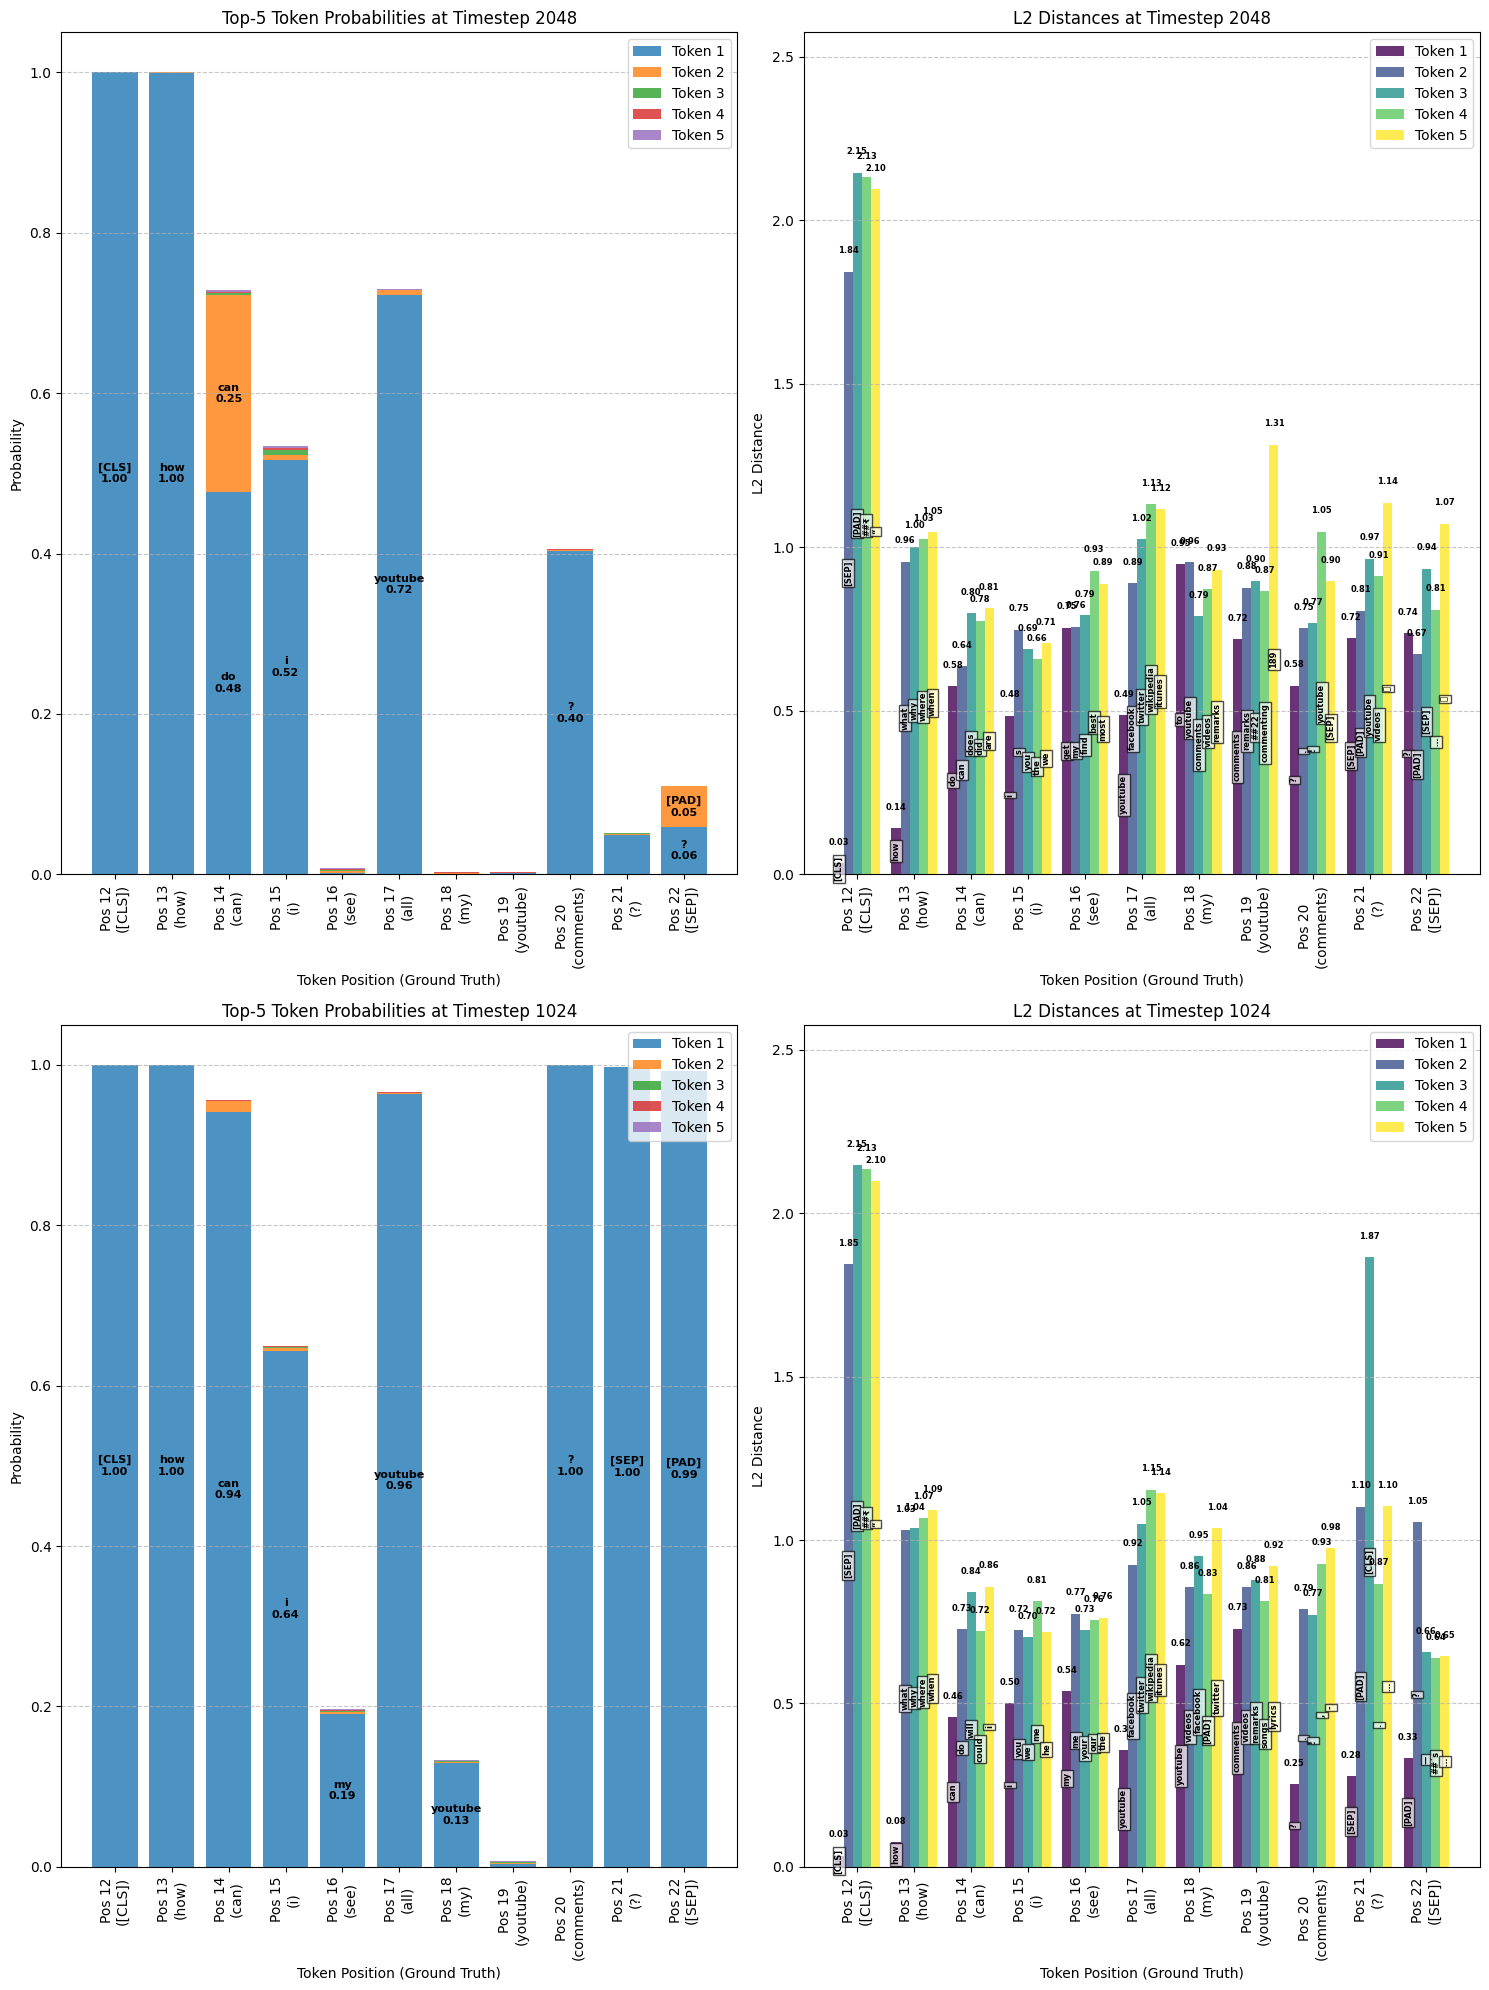


Top tokens at the final timestep (1024):
Position 12 (Ground truth: [CLS]):
  1. [CLS] (prob: 1.0000)
  2. [SEP] (prob: 0.0000)
  3. [PAD] (prob: 0.0000)
  4. ##₹ (prob: 0.0000)
  5. “ (prob: 0.0000)

Position 13 (Ground truth: how):
  1. how (prob: 1.0000)
  2. what (prob: 0.0000)
  3. why (prob: 0.0000)
  4. where (prob: 0.0000)
  5. when (prob: 0.0000)

Position 14 (Ground truth: can):
  1. can (prob: 0.9409)
  2. do (prob: 0.0142)
  3. will (prob: 0.0006)
  4. could (prob: 0.0004)
  5. i (prob: 0.0003)

Position 15 (Ground truth: i):
  1. i (prob: 0.6437)
  2. you (prob: 0.0032)
  3. we (prob: 0.0016)
  4. me (prob: 0.0009)
  5. he (prob: 0.0006)

Position 16 (Ground truth: see):
  1. my (prob: 0.1908)
  2. me (prob: 0.0018)
  3. your (prob: 0.0016)
  4. our (prob: 0.0011)
  5. the (prob: 0.0010)

Position 17 (Ground truth: all):
  1. youtube (prob: 0.9639)
  2. facebook (prob: 0.0015)
  3. twitter (prob: 0.0002)
  4. wikipedia (prob: 0.0001)
  5. itunes (prob: 0.0001)

Position 1

In [5]:

# Set parameters
shortcut_size = 1024
top_k = 5
example_idx = 0

# Run analysis without saving figures
token_results = analyze_token_predictions(
    unit,
    test_batch,
    shortcut_size,
    top_k=top_k,
    example_idx=example_idx,
    save_path=None  # Set to None to not save figures
)

## Analyze Multiple Examples



Analyzing example 0...
Running token tracking...

Input sequence (showing only non-padding tokens):
0: 101 (Input)
1: 2129 (Input)
2: 2079 (Input)
3: 1045 (Input)
4: 3191 (Input)
5: 1998 (Input)
6: 2424 (Input)
7: 2026 (Input)
8: 7858 (Input)
9: 7928 (Input)
10: 1029 (Input)
11: 102 (Input)
12: 101 (Target)
13: 2129 (Target)
14: 2064 (Target)
15: 1045 (Target)
16: 2156 (Target)
17: 2035 (Target)
18: 2026 (Target)
19: 7858 (Target)
20: 7928 (Target)
21: 1029 (Target)
22: 102 (Target)

Positions that contribute to the loss (non-input, non-padding):
[12 13 14 15 16 17 18 19 20 21 22]

Ground truth tokens at loss positions:
Position 12: [CLS]
Position 13: how
Position 14: can
Position 15: i
Position 16: see
Position 17: all
Position 18: my
Position 19: youtube
Position 20: comments
Position 21: ?
Position 22: [SEP]


d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


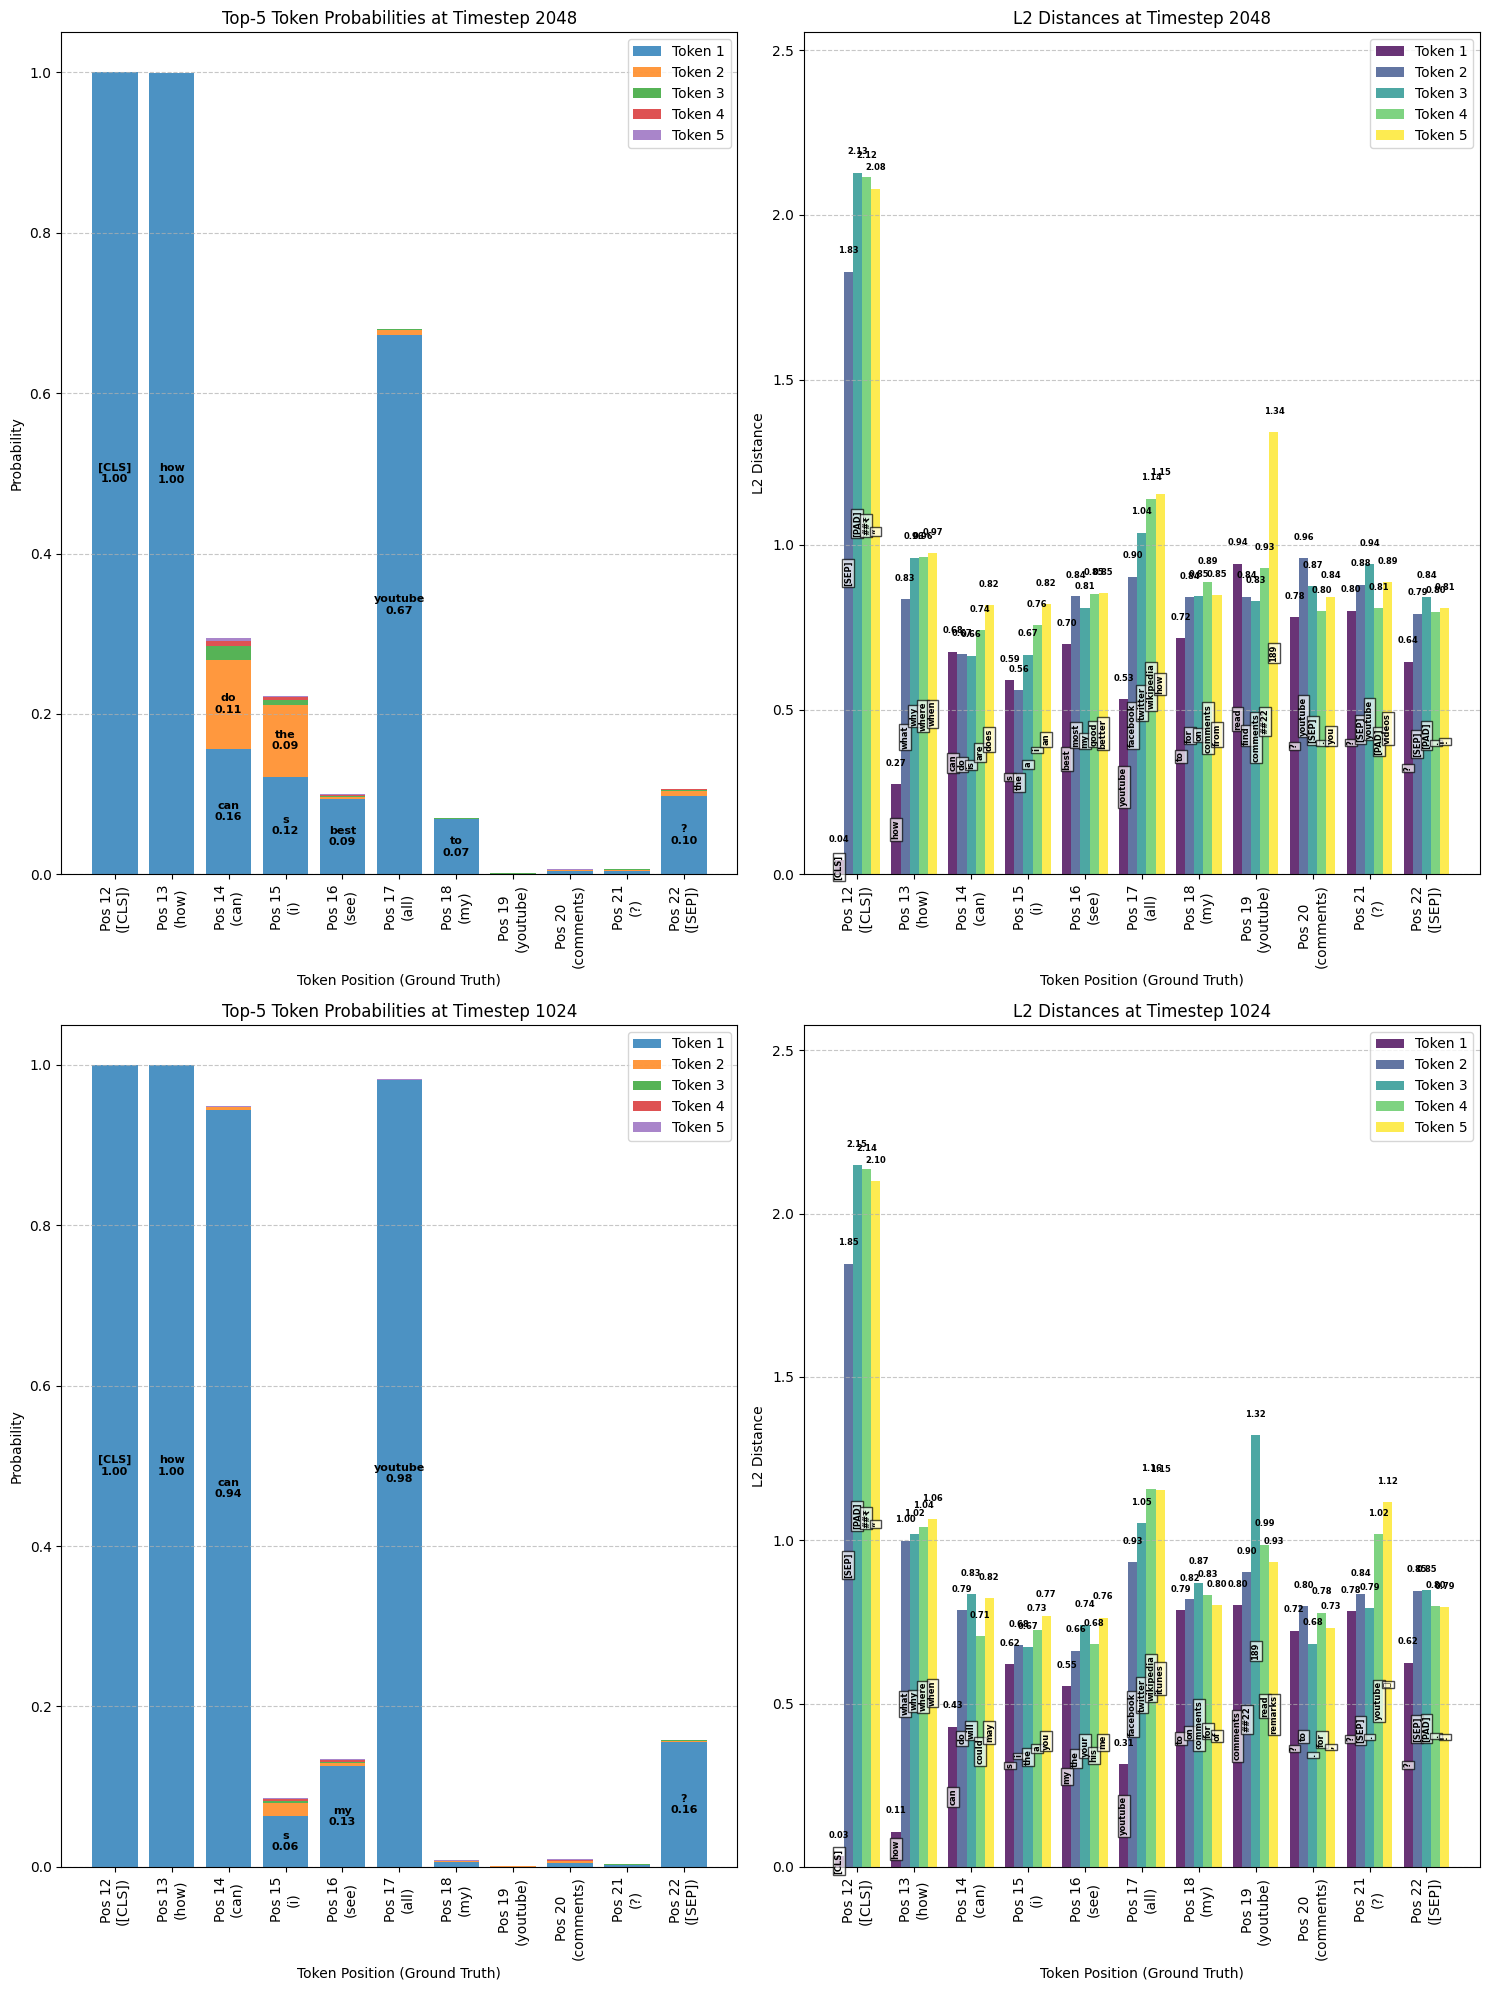


Top tokens at the final timestep (1024):
Position 12 (Ground truth: [CLS]):
  1. [CLS] (prob: 1.0000)
  2. [SEP] (prob: 0.0000)
  3. [PAD] (prob: 0.0000)
  4. ##₹ (prob: 0.0000)
  5. “ (prob: 0.0000)

Position 13 (Ground truth: how):
  1. how (prob: 1.0000)
  2. what (prob: 0.0000)
  3. why (prob: 0.0000)
  4. where (prob: 0.0000)
  5. when (prob: 0.0000)

Position 14 (Ground truth: can):
  1. can (prob: 0.9437)
  2. do (prob: 0.0034)
  3. will (prob: 0.0005)
  4. could (prob: 0.0005)
  5. may (prob: 0.0002)

Position 15 (Ground truth: i):
  1. s (prob: 0.0636)
  2. i (prob: 0.0163)
  3. the (prob: 0.0026)
  4. a (prob: 0.0023)
  5. you (prob: 0.0013)

Position 16 (Ground truth: see):
  1. my (prob: 0.1253)
  2. the (prob: 0.0038)
  3. your (prob: 0.0019)
  4. his (prob: 0.0016)
  5. me (prob: 0.0015)

Position 17 (Ground truth: all):
  1. youtube (prob: 0.9806)
  2. facebook (prob: 0.0010)
  3. twitter (prob: 0.0001)
  4. wikipedia (prob: 0.0001)
  5. itunes (prob: 0.0000)

Position 

d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


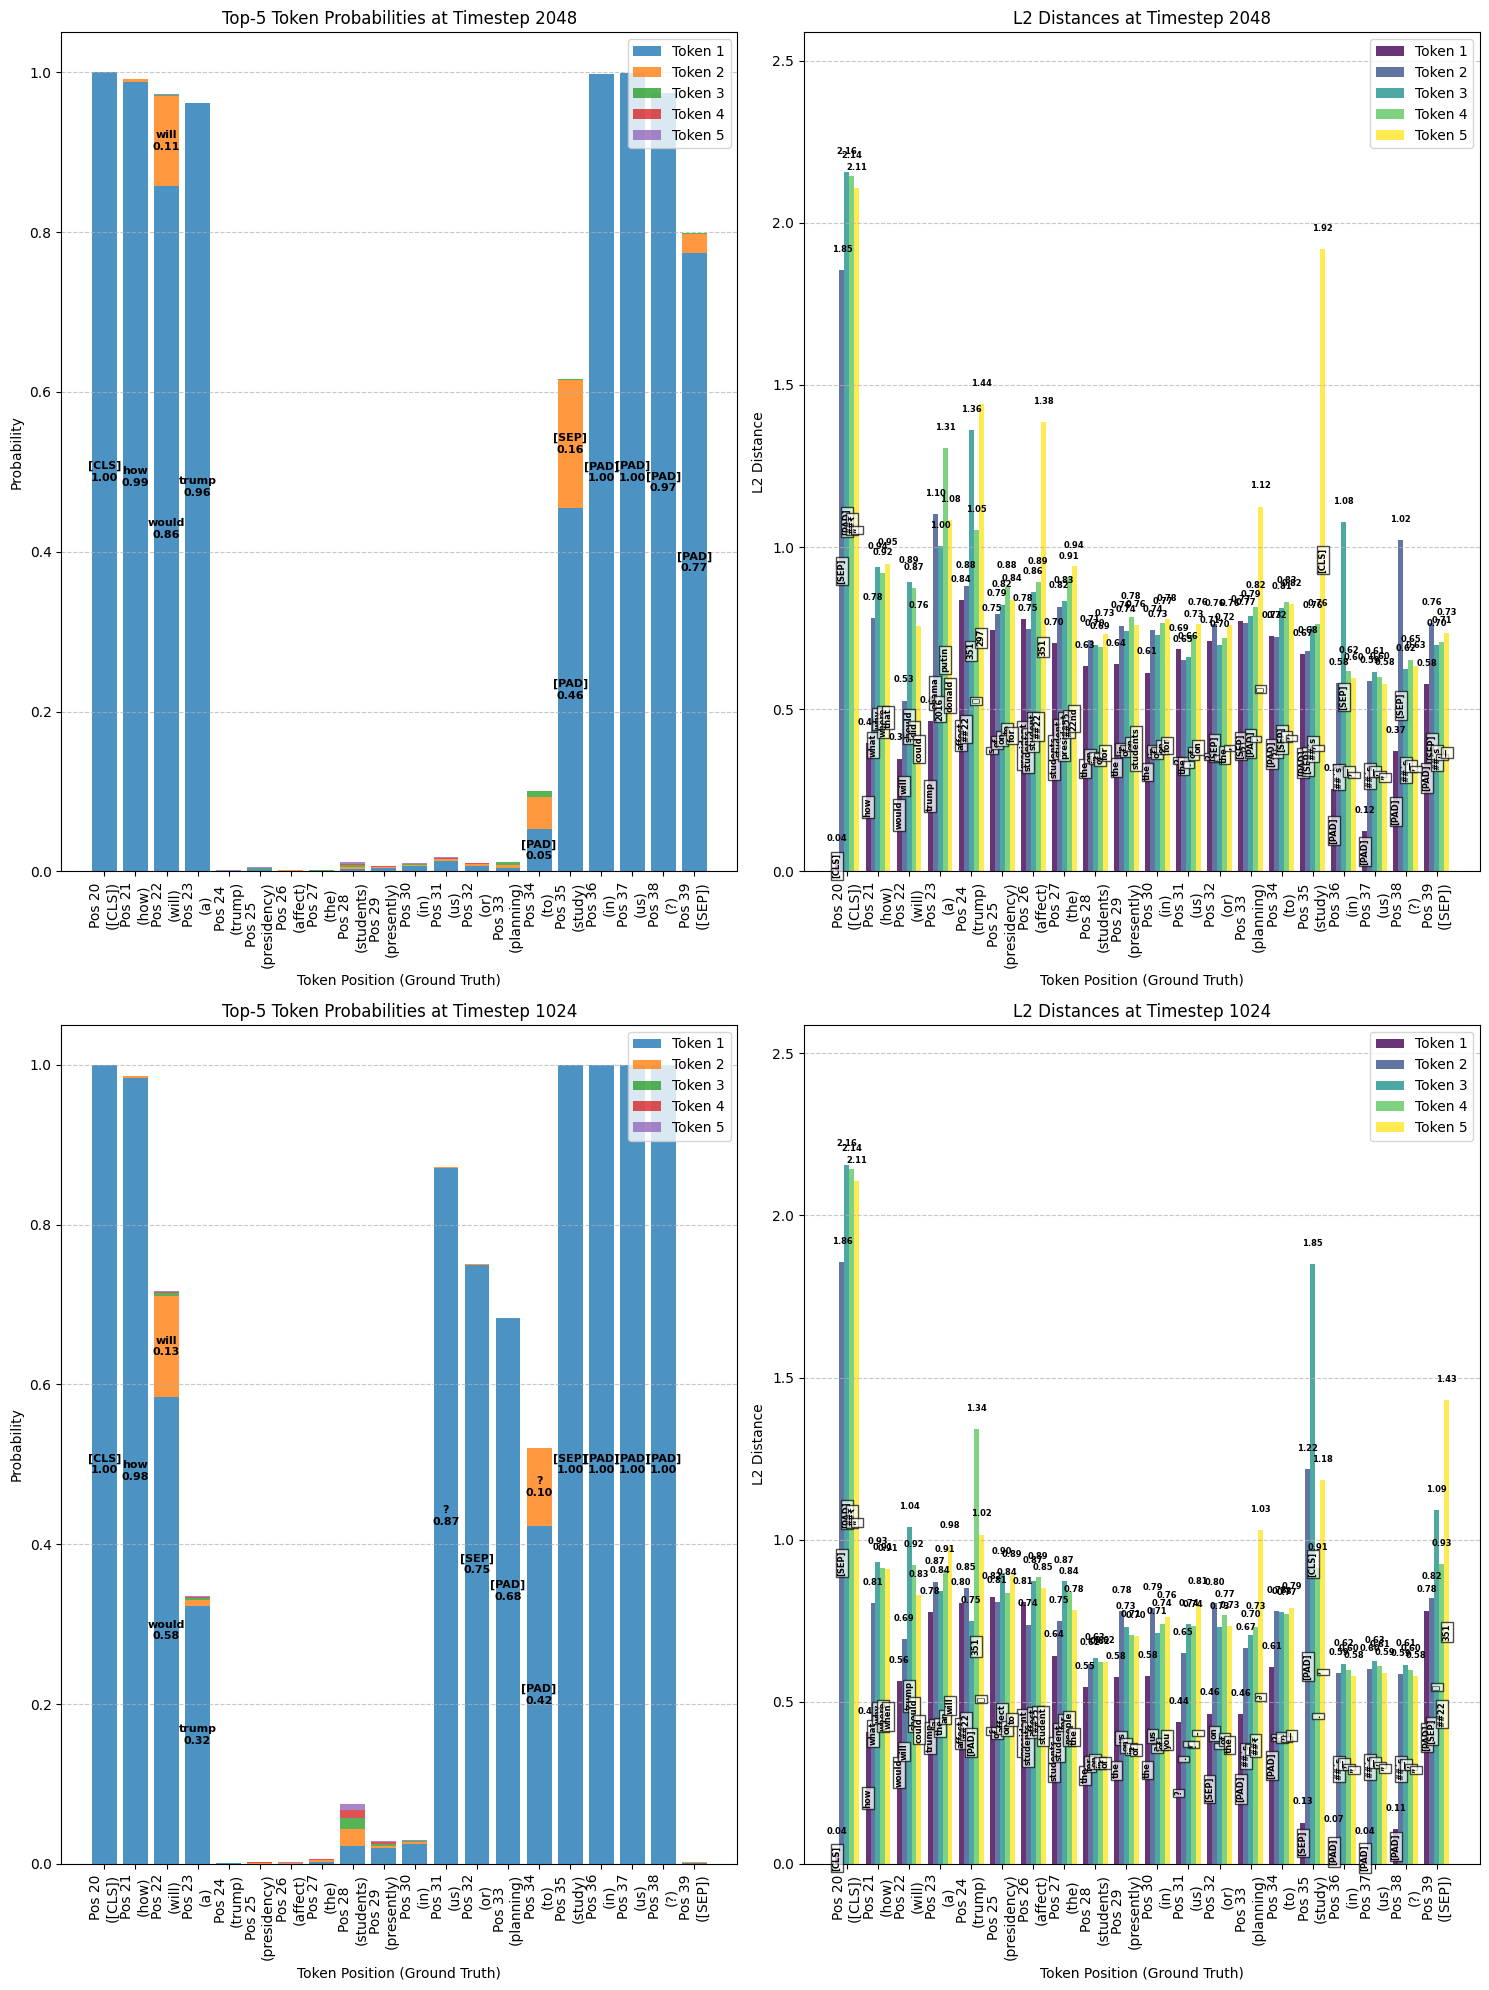


Top tokens at the final timestep (1024):
Position 20 (Ground truth: [CLS]):
  1. [CLS] (prob: 1.0000)
  2. [SEP] (prob: 0.0000)
  3. [PAD] (prob: 0.0000)
  4. ##₹ (prob: 0.0000)
  5. “ (prob: 0.0000)

Position 21 (Ground truth: how):
  1. how (prob: 0.9835)
  2. what (prob: 0.0022)
  3. why (prob: 0.0002)
  4. where (prob: 0.0001)
  5. when (prob: 0.0000)

Position 22 (Ground truth: will):
  1. would (prob: 0.5841)
  2. will (prob: 0.1266)
  3. trump (prob: 0.0032)
  4. should (prob: 0.0015)
  5. could (prob: 0.0013)

Position 23 (Ground truth: a):
  1. trump (prob: 0.3227)
  2. a (prob: 0.0074)
  3. the (prob: 0.0030)
  4. an (prob: 0.0014)
  5. will (prob: 0.0013)

Position 24 (Ground truth: trump):
  1. affect (prob: 0.0007)
  2. ##22 (prob: 0.0003)
  3. [PAD] (prob: 0.0002)
  4. 351 (prob: 0.0002)
  5. ह (prob: 0.0002)

Position 25 (Ground truth: presidency):
  1. s (prob: 0.0006)
  2. of (prob: 0.0005)
  3. affect (prob: 0.0005)
  4. on (prob: 0.0005)
  5. to (prob: 0.0004)

Posi

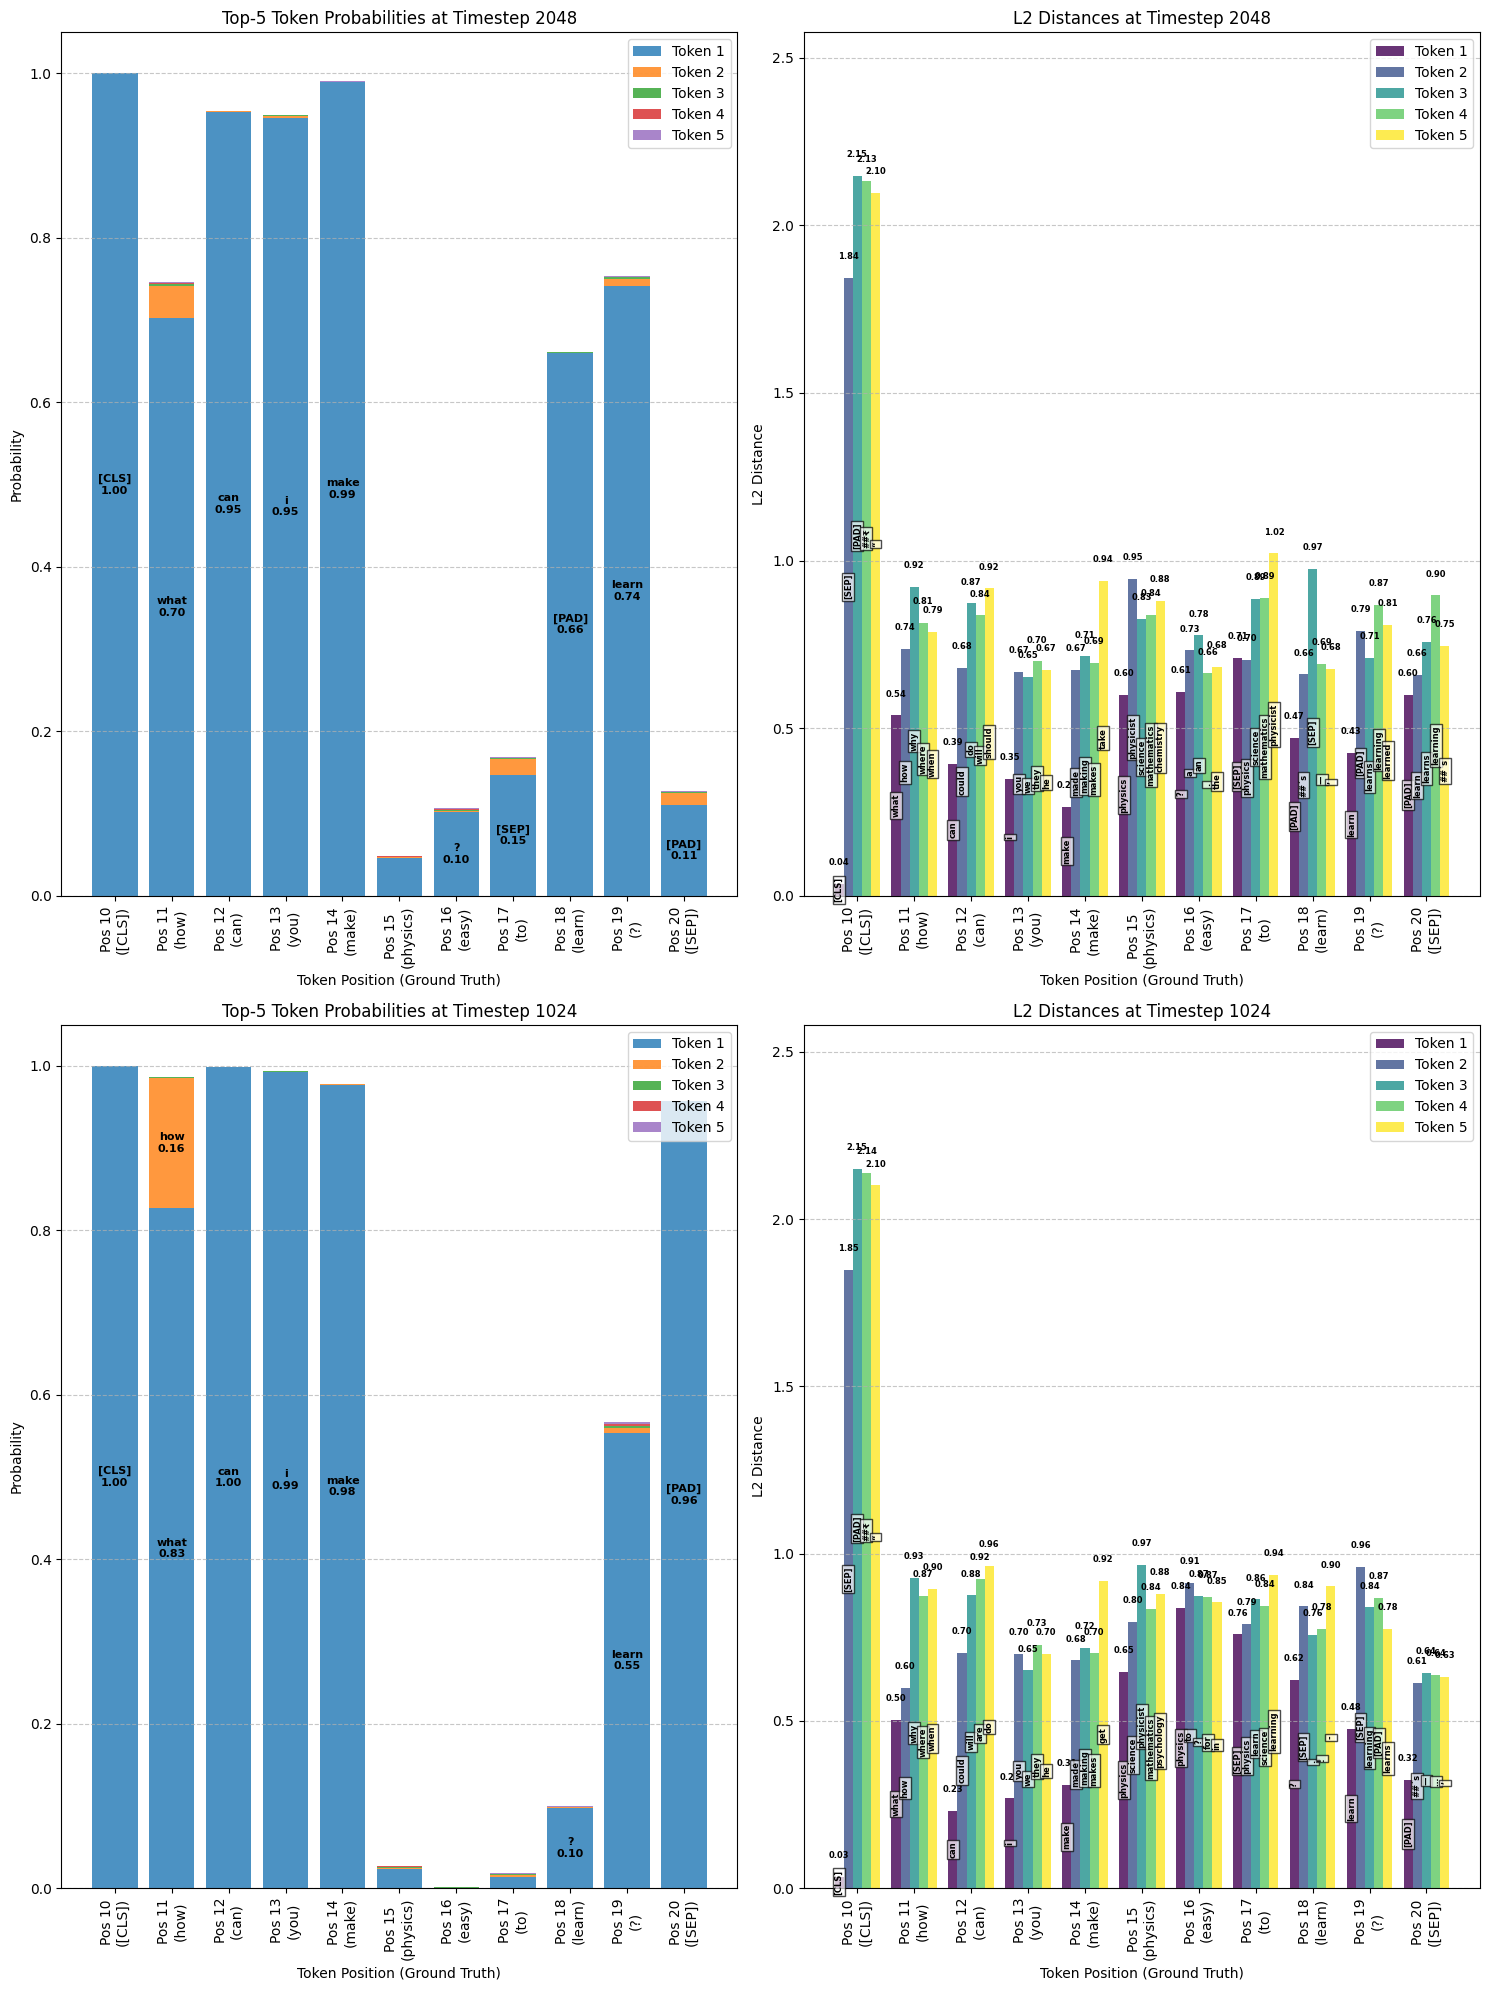


Top tokens at the final timestep (1024):
Position 10 (Ground truth: [CLS]):
  1. [CLS] (prob: 1.0000)
  2. [SEP] (prob: 0.0000)
  3. [PAD] (prob: 0.0000)
  4. ##₹ (prob: 0.0000)
  5. “ (prob: 0.0000)

Position 11 (Ground truth: how):
  1. what (prob: 0.8268)
  2. how (prob: 0.1590)
  3. why (prob: 0.0007)
  4. where (prob: 0.0003)
  5. when (prob: 0.0001)

Position 12 (Ground truth: can):
  1. can (prob: 0.9988)
  2. could (prob: 0.0000)
  3. will (prob: 0.0000)
  4. are (prob: 0.0000)
  5. do (prob: 0.0000)

Position 13 (Ground truth: you):
  1. i (prob: 0.9926)
  2. you (prob: 0.0004)
  3. we (prob: 0.0003)
  4. they (prob: 0.0001)
  5. he (prob: 0.0001)

Position 14 (Ground truth: make):
  1. make (prob: 0.9774)
  2. made (prob: 0.0005)
  3. making (prob: 0.0003)
  4. makes (prob: 0.0003)
  5. get (prob: 0.0002)

Position 15 (Ground truth: physics):
  1. physics (prob: 0.0235)
  2. science (prob: 0.0015)
  3. physicist (prob: 0.0009)
  4. mathematics (prob: 0.0008)
  5. psychology 

In [6]:
# Analyze multiple examples
for i in range(3):  # Analyze first 3 examples
    print(f"\n\nAnalyzing example {i}...")
    token_results = analyze_token_predictions(
        unit,
        test_batch,
        shortcut_size,
        top_k=top_k,
        example_idx=i,
        save_path=None
    )

## Customize Visualization

d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


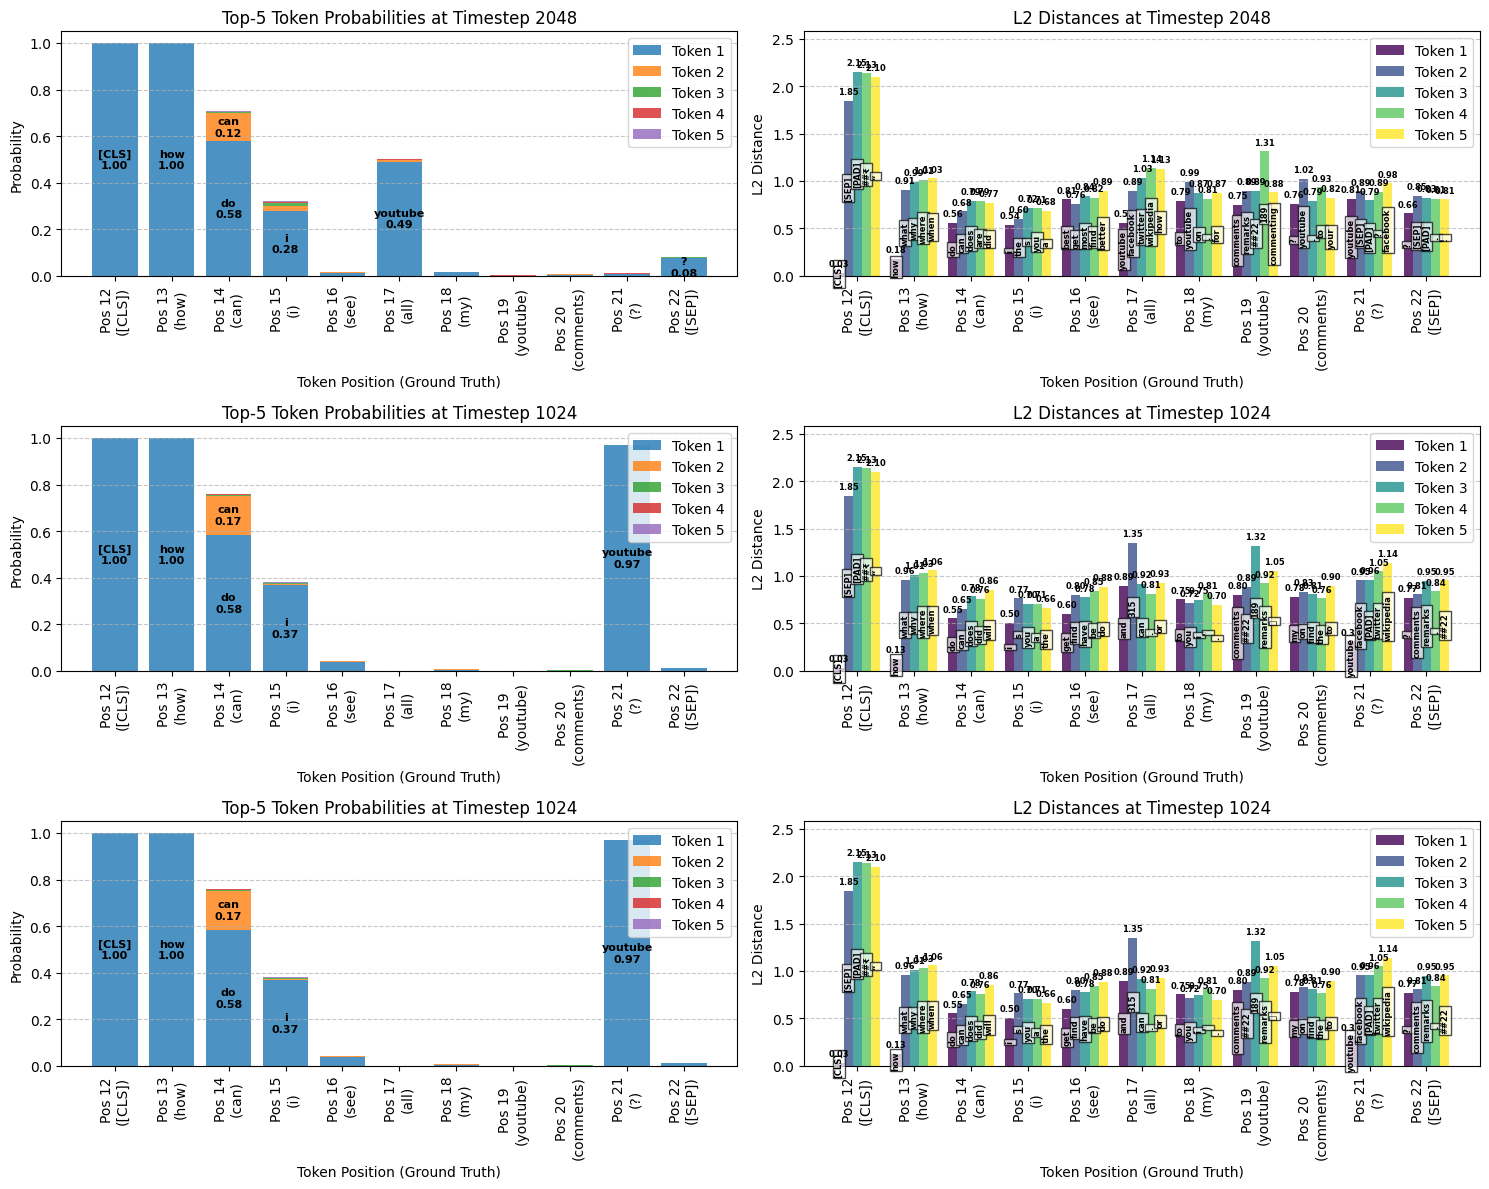

In [7]:

# Run denoising with token tracking
token_results = denoise_with_token_tracking(
    unit,
    test_batch,
    shortcut_size,
    top_k=top_k,
    example_idx=example_idx
)

# Select specific timesteps to visualize
timesteps = token_results["timesteps"]
num_steps = len(timesteps)
timestep_indices = [0, num_steps // 2, num_steps - 1]  # First, middle, last

# Customize figure size
figsize = (15, 12)

# Visualize the selected timesteps
visualize_top_k_tokens(
    token_results,
    timestep_indices=timestep_indices,
    figsize=figsize,
    save_path=None
)

## Save Figures

Running token tracking...

Input sequence (showing only non-padding tokens):
0: 101 (Input)
1: 2129 (Input)
2: 2079 (Input)
3: 1045 (Input)
4: 3191 (Input)
5: 1998 (Input)
6: 2424 (Input)
7: 2026 (Input)
8: 7858 (Input)
9: 7928 (Input)
10: 1029 (Input)
11: 102 (Input)
12: 101 (Target)
13: 2129 (Target)
14: 2064 (Target)
15: 1045 (Target)
16: 2156 (Target)
17: 2035 (Target)
18: 2026 (Target)
19: 7858 (Target)
20: 7928 (Target)
21: 1029 (Target)
22: 102 (Target)

Positions that contribute to the loss (non-input, non-padding):
[12 13 14 15 16 17 18 19 20 21 22]

Ground truth tokens at loss positions:
Position 12: [CLS]
Position 13: how
Position 14: can
Position 15: i
Position 16: see
Position 17: all
Position 18: my
Position 19: youtube
Position 20: comments
Position 21: ?
Position 22: [SEP]


d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:332: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:337: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  plt.savefig(save_path, dpi=300, bbox_inches="tight")
d:\Side-Projects\ShortcutFM\notebooks\..\shortcutfm\analysis\token_analysis.py:337: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.savefig(save_path, dpi=300, bbox_inches="tight")
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byt

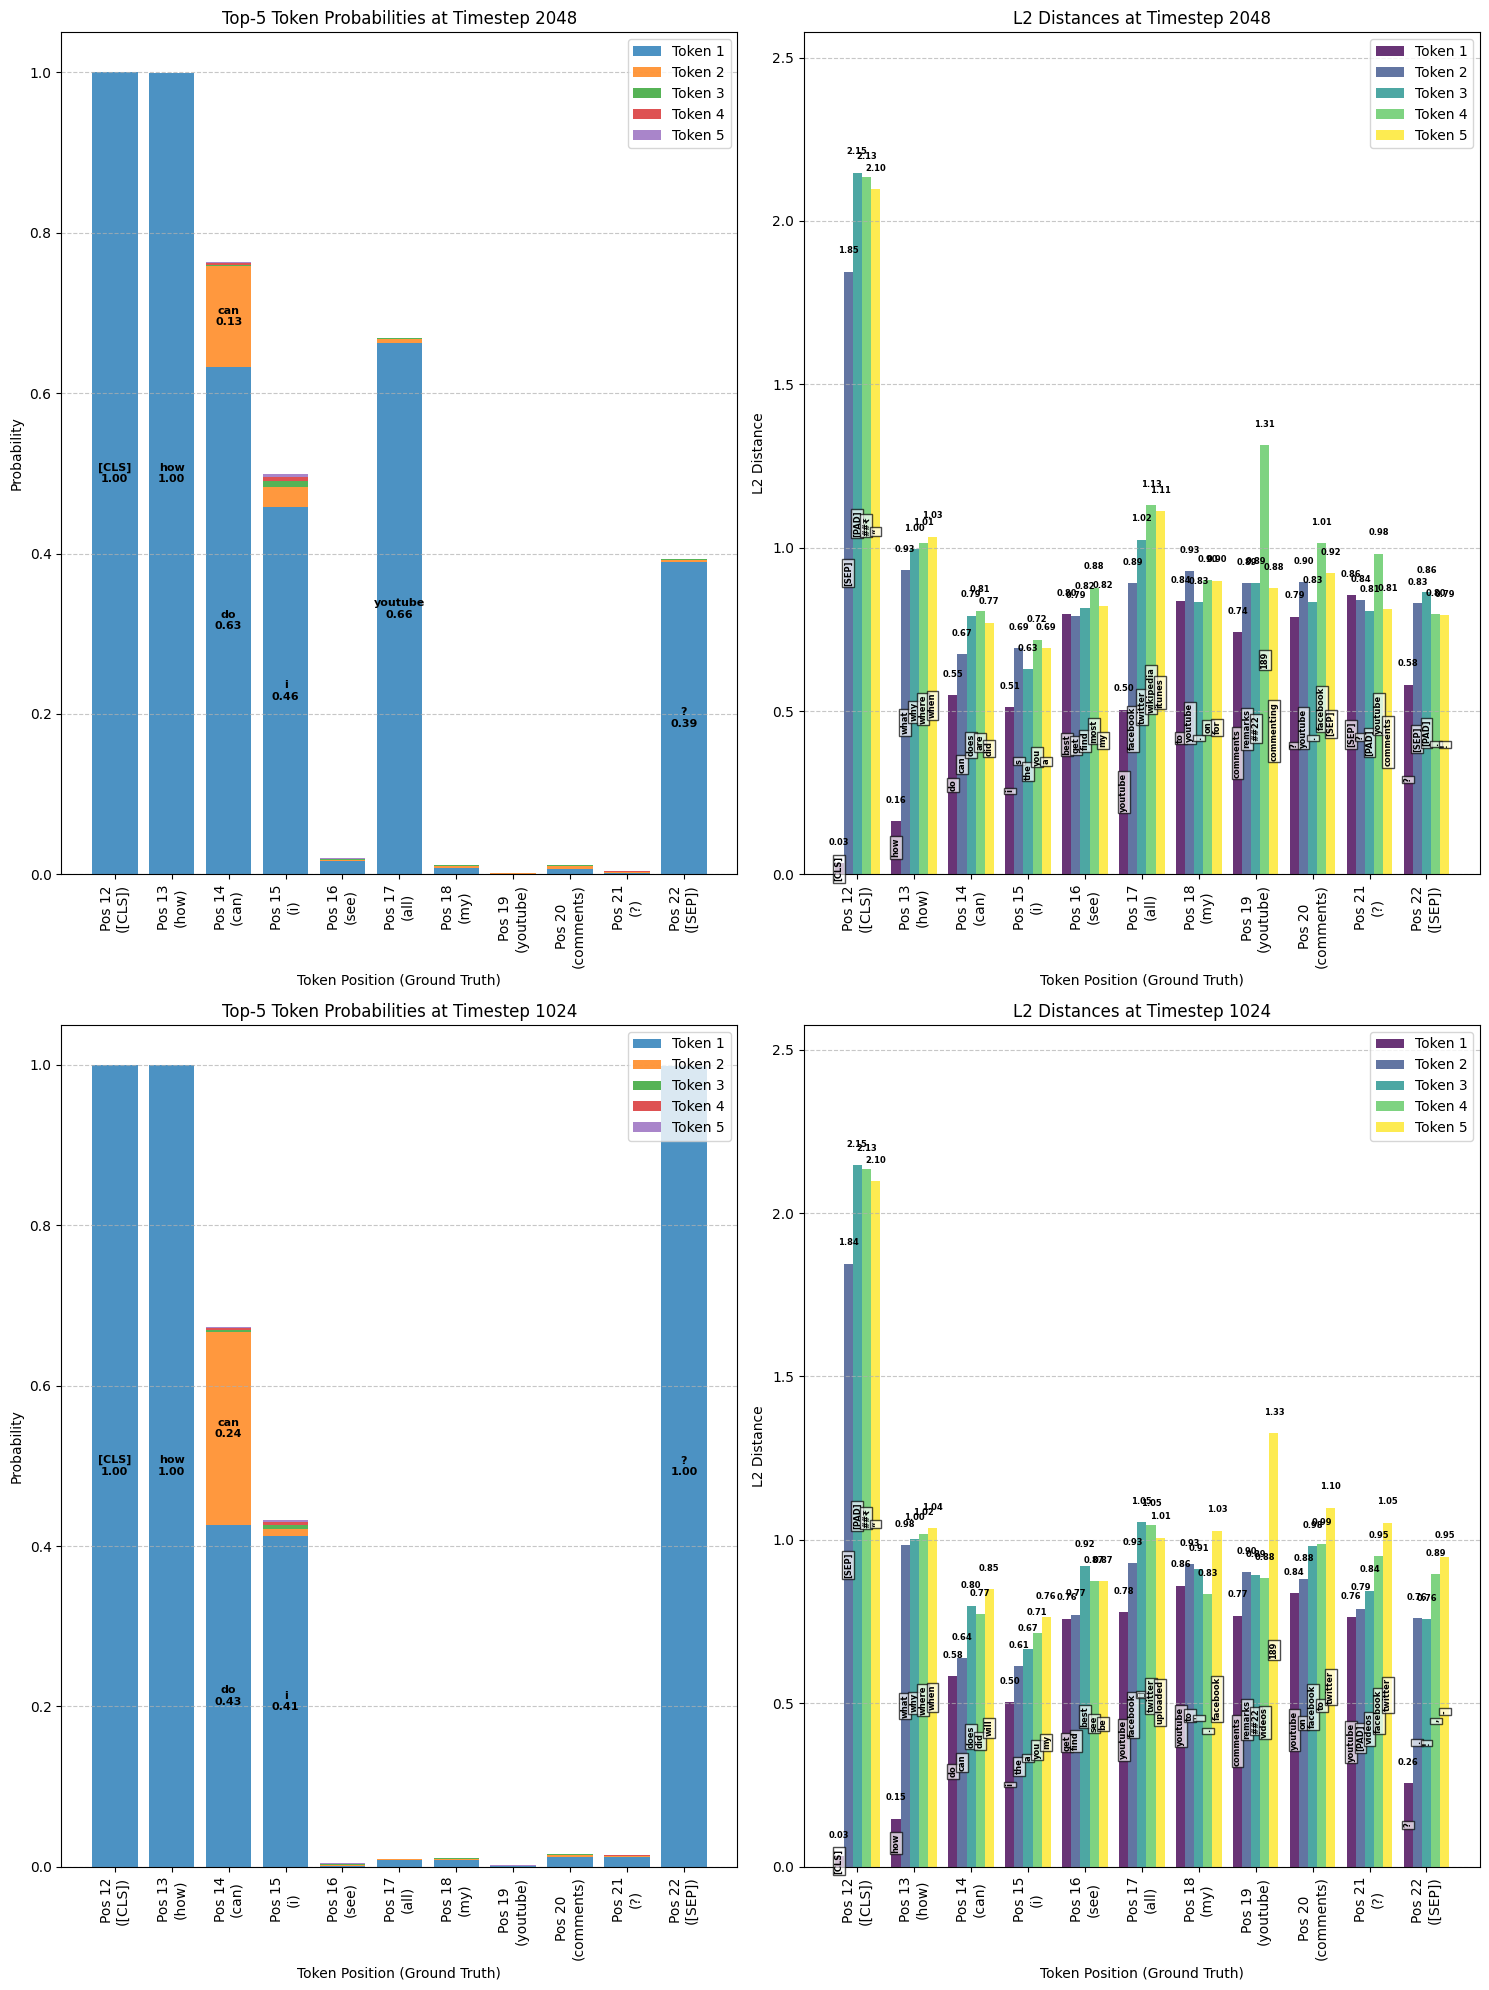


Top tokens at the final timestep (1024):
Position 12 (Ground truth: [CLS]):
  1. [CLS] (prob: 1.0000)
  2. [SEP] (prob: 0.0000)
  3. [PAD] (prob: 0.0000)
  4. ##₹ (prob: 0.0000)
  5. “ (prob: 0.0000)

Position 13 (Ground truth: how):
  1. how (prob: 0.9999)
  2. what (prob: 0.0000)
  3. why (prob: 0.0000)
  4. where (prob: 0.0000)
  5. when (prob: 0.0000)

Position 14 (Ground truth: can):
  1. do (prob: 0.4259)
  2. can (prob: 0.2410)
  3. does (prob: 0.0024)
  4. did (prob: 0.0020)
  5. will (prob: 0.0017)

Position 15 (Ground truth: i):
  1. i (prob: 0.4126)
  2. the (prob: 0.0081)
  3. a (prob: 0.0058)
  4. you (prob: 0.0031)
  5. my (prob: 0.0025)

Position 16 (Ground truth: see):
  1. get (prob: 0.0014)
  2. find (prob: 0.0012)
  3. best (prob: 0.0011)
  4. see (prob: 0.0004)
  5. be (prob: 0.0003)

Position 17 (Ground truth: all):
  1. youtube (prob: 0.0085)
  2. facebook (prob: 0.0008)
  3. ह (prob: 0.0004)
  4. twitter (prob: 0.0003)
  5. uploaded (prob: 0.0002)

Position 18 (

In [8]:
# Create output directory
output_dir = "../reports/figures"
os.makedirs(output_dir, exist_ok=True)

# Run analysis and save figure
output_path = os.path.join(output_dir, f"token_analysis_example_{example_idx}.png")
token_results = analyze_token_predictions(
    unit,
    test_batch,
    shortcut_size,
    top_k=top_k,
    example_idx=example_idx,
    save_path=output_path
)

print(f"Figure saved to {output_path}")

In [11]:
import torch
from typing import Any


In [12]:


def get_ground_truth_token_id_and_embedding(tokenizer, word_embeddings, original_sequence, loss_positions, position_idx):
    """
    Get the ground truth token id and embedding for the given position.
    """
    gt_pos = loss_positions[position_idx]
    ground_truth_id = int(original_sequence[gt_pos])
    ground_truth_emb = word_embeddings[ground_truth_id]
    return gt_pos, ground_truth_id, ground_truth_emb


def get_knn_indices_and_distances(word_embeddings, predicted_emb, ground_truth_id, k):
    """
    Get kNN indices and distances, excluding the ground truth if present.
    """
    with torch.no_grad():
        distances = torch.norm(word_embeddings - predicted_emb, dim=1)
        knn_distances, knn_indices = torch.topk(distances, k=k + 1, largest=False)
        knn_indices = knn_indices.cpu().numpy()
        knn_distances = knn_distances.cpu().numpy()
        if ground_truth_id in knn_indices:
            mask = knn_indices != ground_truth_id
            knn_distances = knn_distances[mask][:k]
            knn_indices = knn_indices[mask][:k]
        else:
            knn_distances = knn_distances[:k]
            knn_indices = knn_indices[:k]
    return knn_indices, knn_distances


def get_topk_logit_indices(model, x0_hat, gt_pos, k):
    """
    Get top-k logit indices for the given position.
    """
    with torch.no_grad():
        logits = model.criterion.model.compute_logits(x0_hat)  # [batch, seq, vocab]
        pos_logits = logits[0, gt_pos]  # [vocab]
        _, topk_logit_indices = torch.topk(pos_logits, k=k)
        topk_logit_indices = topk_logit_indices.cpu().numpy()
    return topk_logit_indices


def build_unique_embeddings_and_roles(predicted_emb, ground_truth_emb, ground_truth_id, word_embeddings, knn_indices, topk_logit_indices):
    """
    Build unique embedding list, token ids, and roles for each embedding.
    """
    import collections
    unique_embeddings = []
    unique_token_ids = []  # None for predicted, int for vocab tokens
    role_map = {"predicted": None, "ground_truth": None, "knn": [], "logit": []}

    # 1. Add predicted embedding (not a vocab token)
    unique_embeddings.append(predicted_emb)
    unique_token_ids.append(None)
    idx_pred = 0
    role_map["predicted"] = idx_pred

    # 2. Add ground truth token embedding if not already present
    if ground_truth_id not in unique_token_ids:
        unique_embeddings.append(ground_truth_emb)
        unique_token_ids.append(ground_truth_id)
        idx_gt = len(unique_embeddings) - 1
    else:
        idx_gt = unique_token_ids.index(ground_truth_id)
    role_map["ground_truth"] = idx_gt

    # 3. Add kNN tokens, deduplicating
    for idx in knn_indices:
        if idx not in unique_token_ids:
            unique_embeddings.append(word_embeddings[idx])
            unique_token_ids.append(idx)
            role_map["knn"].append(len(unique_embeddings) - 1)
        else:
            role_map["knn"].append(unique_token_ids.index(idx))

    # 4. Add top-k logits tokens, deduplicating
    for idx in topk_logit_indices:
        if idx not in unique_token_ids:
            unique_embeddings.append(word_embeddings[idx])
            unique_token_ids.append(idx)
            role_map["logit"].append(len(unique_embeddings) - 1)
        else:
            role_map["logit"].append(unique_token_ids.index(idx))

    # Build roles_for_index: for each unique embedding index, store a set of roles
    roles_for_index = collections.defaultdict(set)
    roles_for_index[idx_pred].add("predicted")
    roles_for_index[idx_gt].add("ground_truth")
    for idx in role_map["knn"]:
        if idx != idx_pred:
            roles_for_index[idx].add("knn")
    for idx in role_map["logit"]:
        if idx != idx_pred:
            roles_for_index[idx].add("logit")

    return unique_embeddings, unique_token_ids, roles_for_index, idx_pred


def run_tsne(unique_embeddings, figsize, random_state=42):
    import torch
    from sklearn.manifold import TSNE
    embeddings_to_plot = torch.stack(unique_embeddings, dim=0)
    n_points = embeddings_to_plot.shape[0]
    perplexity = min(n_points - 1, 5)
    tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity)
    embeddings_2d = tsne.fit_transform(embeddings_to_plot.cpu().numpy())
    return embeddings_2d


def plot_embeddings_and_edges(
    embeddings_2d,
    unique_embeddings,
    unique_token_ids,
    roles_for_index,
    idx_pred,
    word_embeddings,
    tokenizer,
    gt_pos,
    timesteps,
    timestep_idx,
    save_path=None,
    figsize=(12, 10),
):
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    plt.figure(figsize=figsize)
    legend_handles = [
        Line2D([0], [0], marker="*", color="w", markerfacecolor="red", markersize=14, label="Predicted"),
        Line2D([0], [0], marker="*", color="w", markerfacecolor="green", markersize=14, label="Ground Truth"),
        Line2D([0], [0], marker="o", color="w", markerfacecolor="blue", markersize=10, label="kNN"),
        Line2D([0], [0], marker="s", color="w", markerfacecolor="orange", markersize=10, label="Top-k Logits"),
        Line2D([0], [0], marker="D", color="w", markerfacecolor="purple", markersize=10, label="kNN & Logit"),
    ]
    # Plot predicted embedding
    plt.scatter(embeddings_2d[idx_pred, 0], embeddings_2d[idx_pred, 1], c="red", s=200, marker="*", zorder=10)
    plt.text(
        embeddings_2d[idx_pred, 0],
        embeddings_2d[idx_pred, 1],
        "Predicted",
        fontsize=10,
        ha="center",
        va="bottom",
        color="red",
    )
    for idx in range(1, len(unique_embeddings)):
        roles = roles_for_index[idx]
        token_id = unique_token_ids[idx]
        if token_id is None:
            continue
        if "ground_truth" in roles:
            color = "green"
            marker = "*"
            size = 200
        elif "knn" in roles and "logit" in roles:
            color = "purple"
            marker = "D"
            size = 120
        elif "knn" in roles:
            color = "blue"
            marker = "o"
            size = 100
        elif "logit" in roles:
            color = "orange"
            marker = "s"
            size = 100
        else:
            color = "gray"
            marker = "x"
            size = 80
        role_str = ",".join(sorted(roles))
        token = tokenizer.decode([token_id])
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color, s=size, alpha=0.7, marker=marker, zorder=5)
        plt.text(
            embeddings_2d[idx, 0],
            embeddings_2d[idx, 1],
            f"{token}\n({role_str})",
            fontsize=10,
            ha="center",
            va="bottom",
            color=color,
        )
    # Draw edges from predicted to each unique point (except predicted itself)
    for idx in range(1, len(unique_embeddings)):
        roles = roles_for_index[idx]
        token_id = unique_token_ids[idx]
        if token_id is None:
            continue
        if "ground_truth" in roles:
            edge_color = "g"
            edge_style = "-"
        elif "knn" in roles and "logit" in roles:
            edge_color = "purple"
            edge_style = "-."
        elif "knn" in roles:
            edge_color = "b"
            edge_style = "--"
        elif "logit" in roles:
            edge_color = "orange"
            edge_style = ":"
        else:
            edge_color = "gray"
            edge_style = "-."
        distance = torch.norm(unique_embeddings[idx_pred] - word_embeddings[token_id]).item()
        plt.plot(
            [embeddings_2d[idx_pred, 0], embeddings_2d[idx, 0]],
            [embeddings_2d[idx_pred, 1], embeddings_2d[idx, 1]],
            color=edge_color,
            alpha=0.5,
            linestyle=edge_style,
            linewidth=2,
        )
        mid_x = (embeddings_2d[idx_pred, 0] + embeddings_2d[idx, 0]) / 2
        mid_y = (embeddings_2d[idx_pred, 1] + embeddings_2d[idx, 1]) / 2
        plt.text(
            mid_x,
            mid_y,
            f"{distance:.2f}",
            fontsize=8,
            ha="center",
            va="center",
            bbox=dict(facecolor="white", alpha=0.7, pad=1),
            color=edge_color,
        )
    plt.title(f"KNN vs Top-k Logits at Timestep {timesteps[timestep_idx]}, Position {gt_pos}")
    plt.legend(handles=legend_handles)
    plt.grid(True, alpha=0.3)
    if save_path:
        import os
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


def visualize_knn_embeddings(
    token_results: dict[str, Any],
    timestep_idx: int,
    position_idx: int,
    k: int = 5,
    figsize: tuple[int, int] = (12, 10),
    save_path: str | None = None,
) -> None:
    """
    Visualize k-nearest neighbors of token embeddings in 2D space using t-SNE, and compare to top-k tokens by logits.
    Ensures each unique token embedding is only plotted once, even if it appears in multiple roles.
    Always marks and connects the ground truth token.
    """
    model = token_results["model"]
    tokenizer = model.criterion.flow_matching_criterion.tokenizer
    word_embeddings = model.criterion.model.module.word_embedding.weight
    timesteps = token_results["timesteps"]
    loss_positions = token_results["loss_positions"]
    original_sequence = token_results["original_sequence"]
    x0_hat = token_results["x0_hat"][timestep_idx]
    predicted_emb = x0_hat[0, loss_positions[position_idx]]
    gt_pos, ground_truth_id, ground_truth_emb = get_ground_truth_token_id_and_embedding(
        tokenizer, word_embeddings, original_sequence, loss_positions, position_idx
    )
    knn_indices, knn_distances = get_knn_indices_and_distances(word_embeddings, predicted_emb, ground_truth_id, k)
    topk_logit_indices = get_topk_logit_indices(model, x0_hat, gt_pos, k)
    unique_embeddings, unique_token_ids, roles_for_index, idx_pred = build_unique_embeddings_and_roles(
        predicted_emb, ground_truth_emb, ground_truth_id, word_embeddings, knn_indices, topk_logit_indices
    )
    embeddings_2d = run_tsne(unique_embeddings, figsize)
    plot_embeddings_and_edges(
        embeddings_2d,
        unique_embeddings,
        unique_token_ids,
        roles_for_index,
        idx_pred,
        word_embeddings,
        tokenizer,
        gt_pos,
        timesteps,
        timestep_idx,
        save_path=save_path,
        figsize=figsize,
    )


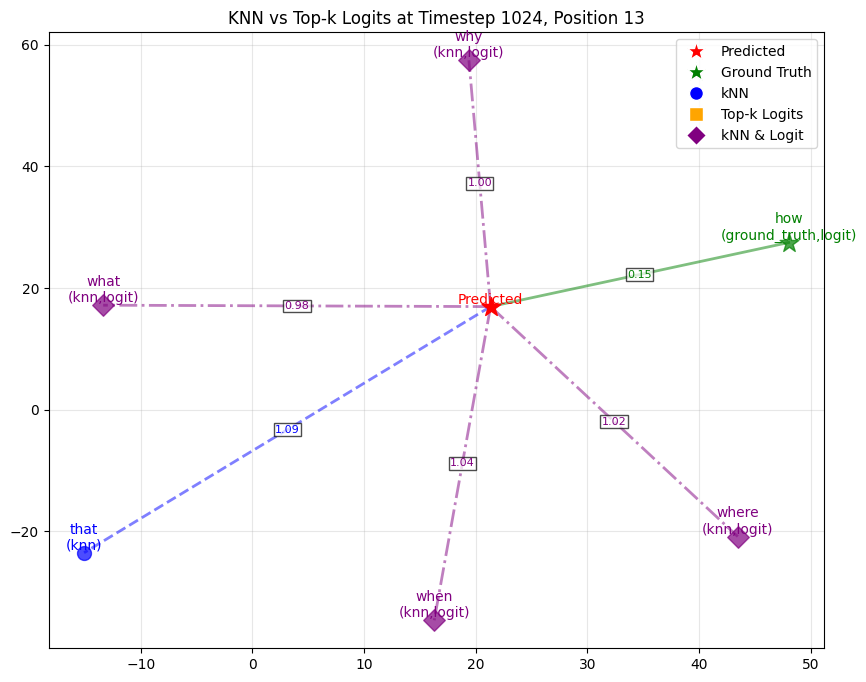

In [13]:
# Visualize k-nearest neighbors for a given position and timestep

# from shortcutfm.analysis.token_analysis import visualize_knn_embeddings

# Choose which timestep and position to visualize
# For example, last timestep and first loss position:
timestep_idx = -1  # last timestep
position_idx = 1   # first position in loss_positions

# You can change k to visualize more or fewer neighbors
k = 5

visualize_knn_embeddings(
    token_results,
    timestep_idx=timestep_idx,
    position_idx=position_idx,
    k=k,
    figsize=(10, 8)
)

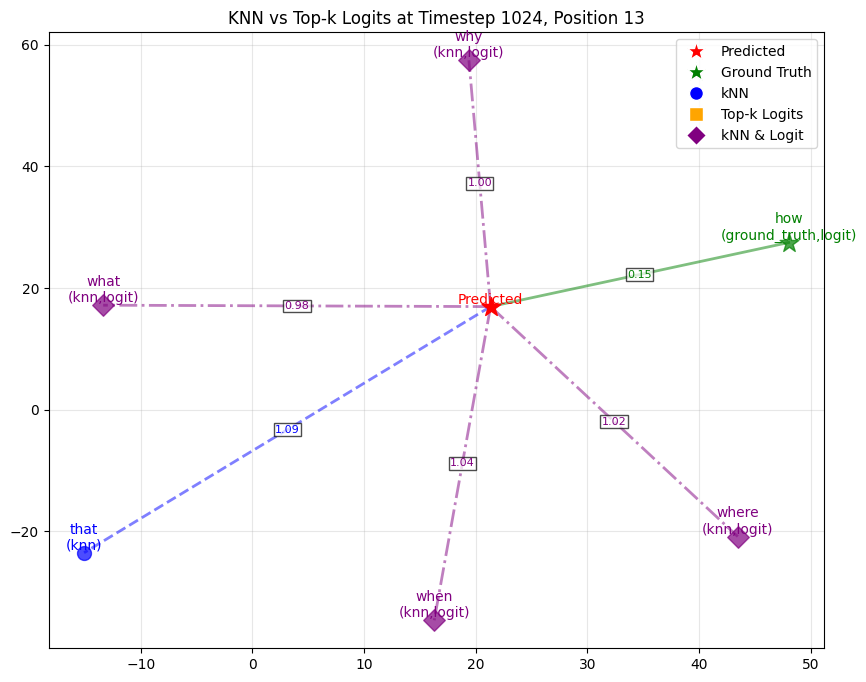

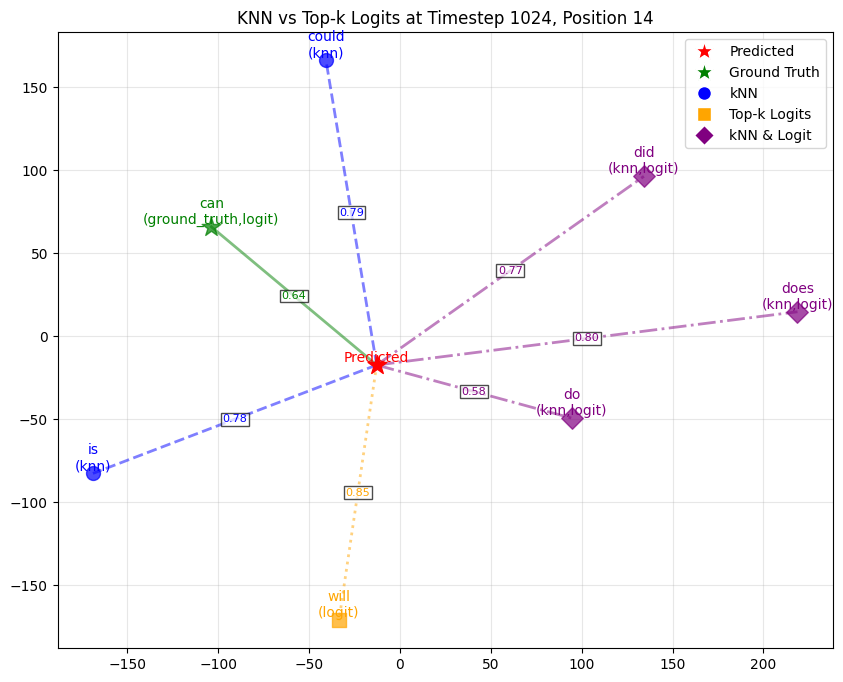

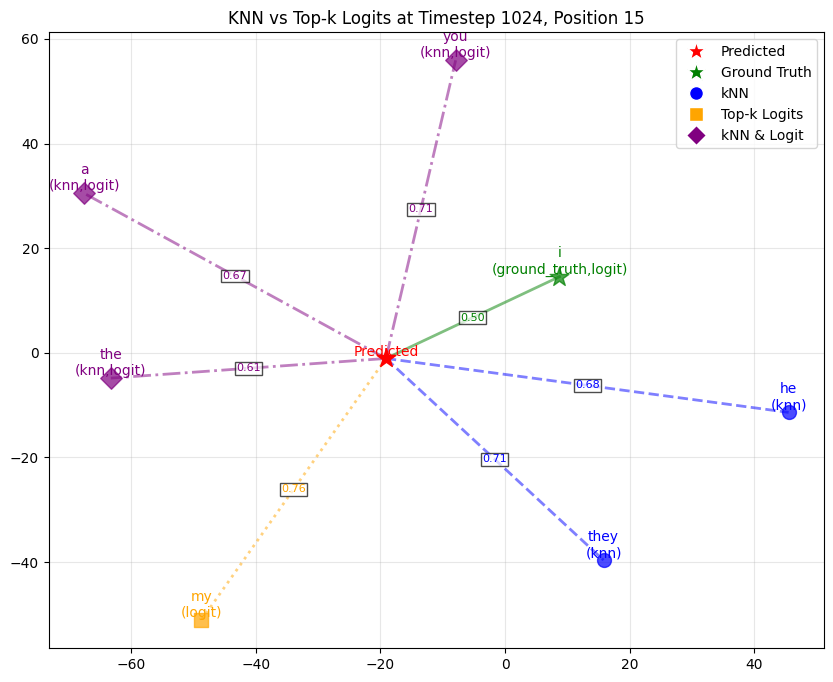

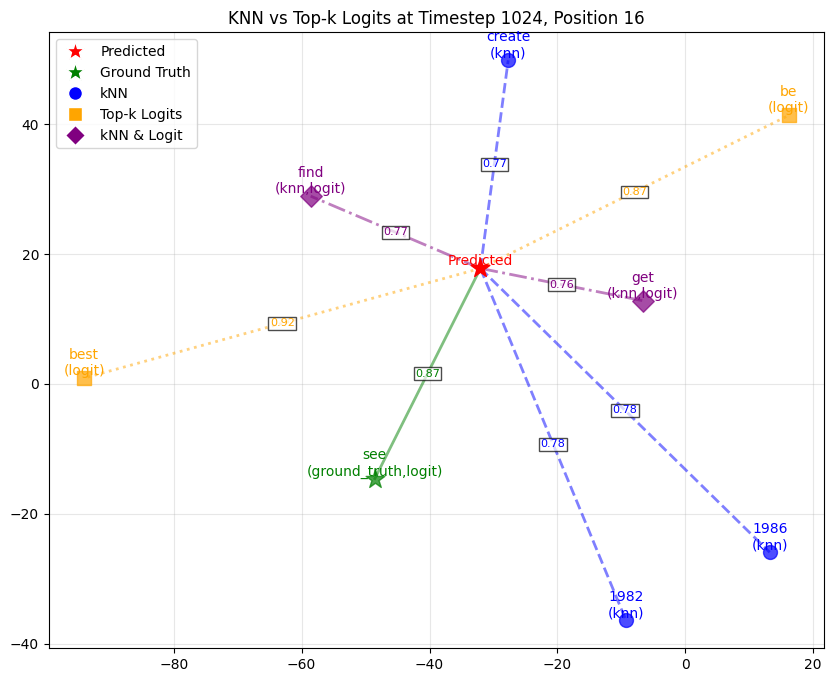

d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2361 (\N{DEVANAGARI LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Side-Projects\ShortcutFM\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


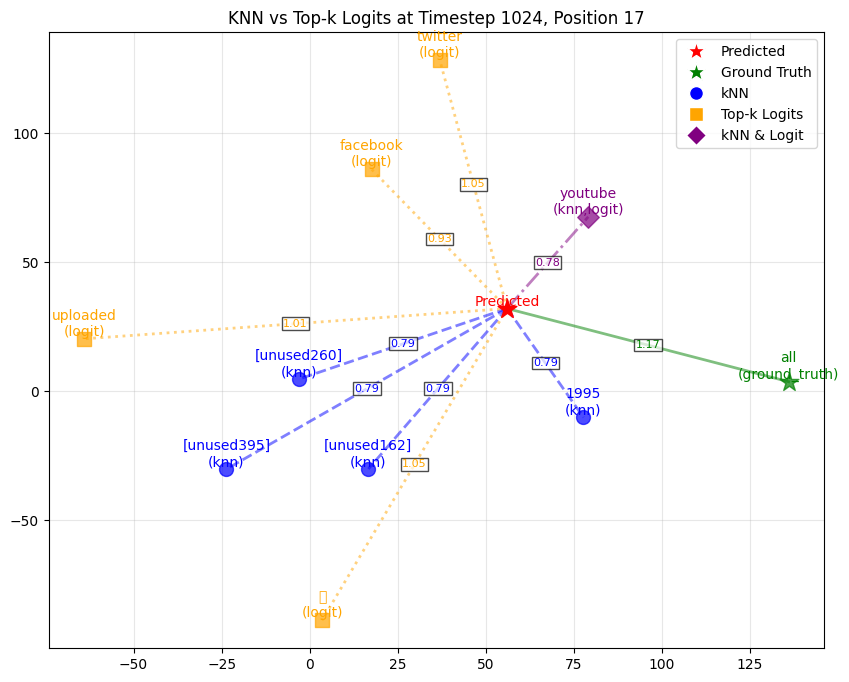

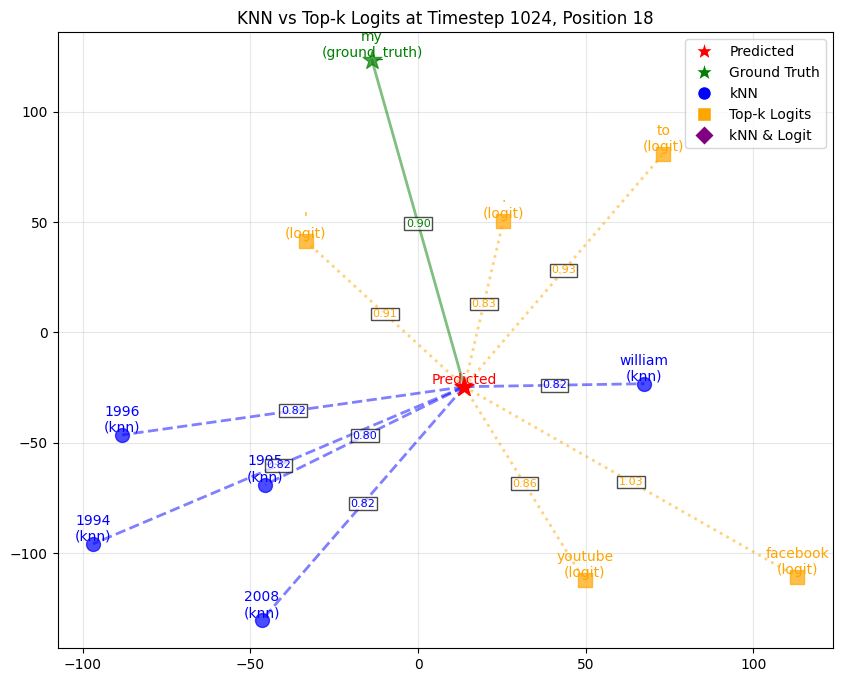

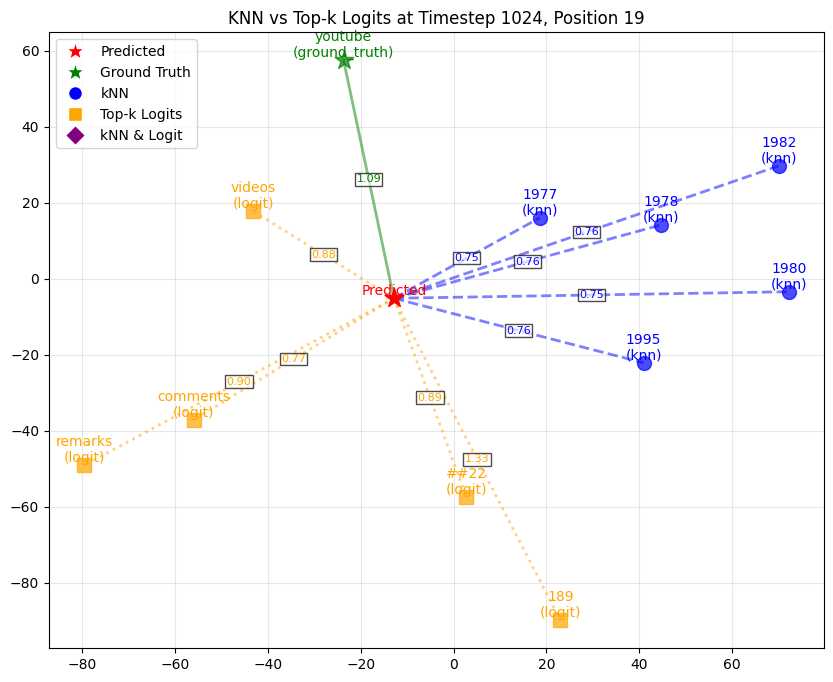

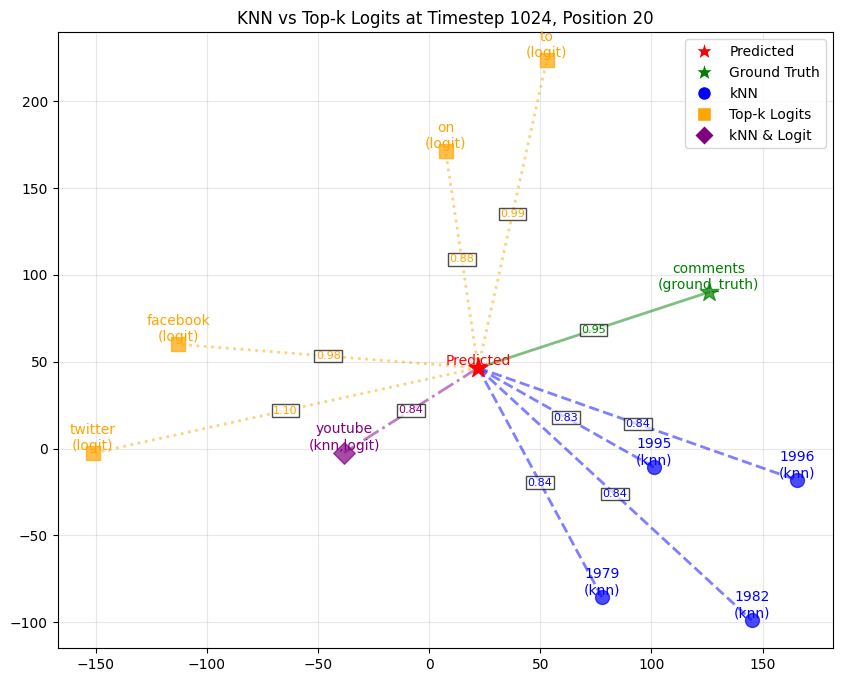

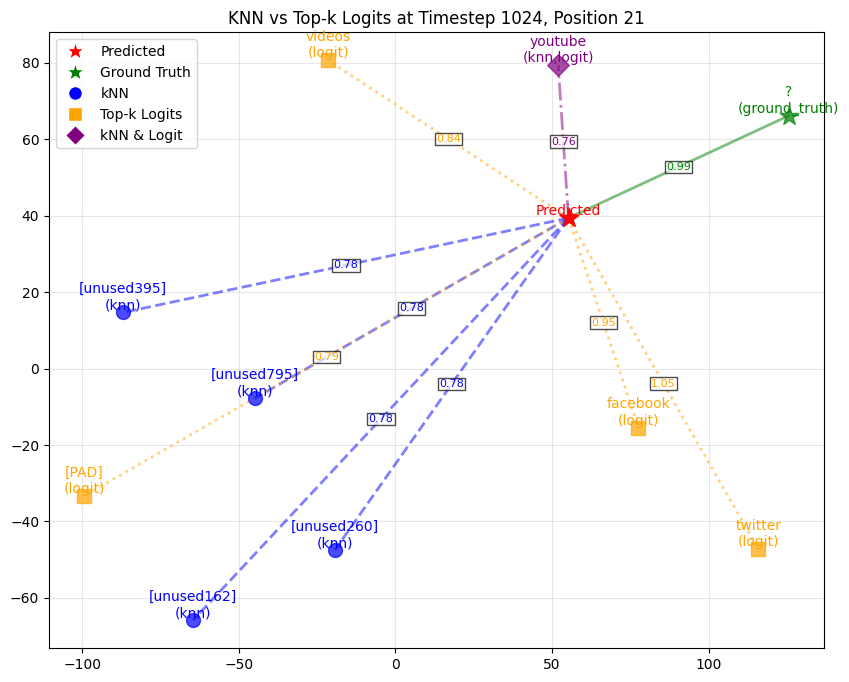

In [14]:
for pos in range(1, 10):
    visualize_knn_embeddings(
    token_results,
    timestep_idx=timestep_idx,
    position_idx=pos,
    k=k,
    figsize=(10, 8)
)


## Trained Embeddings

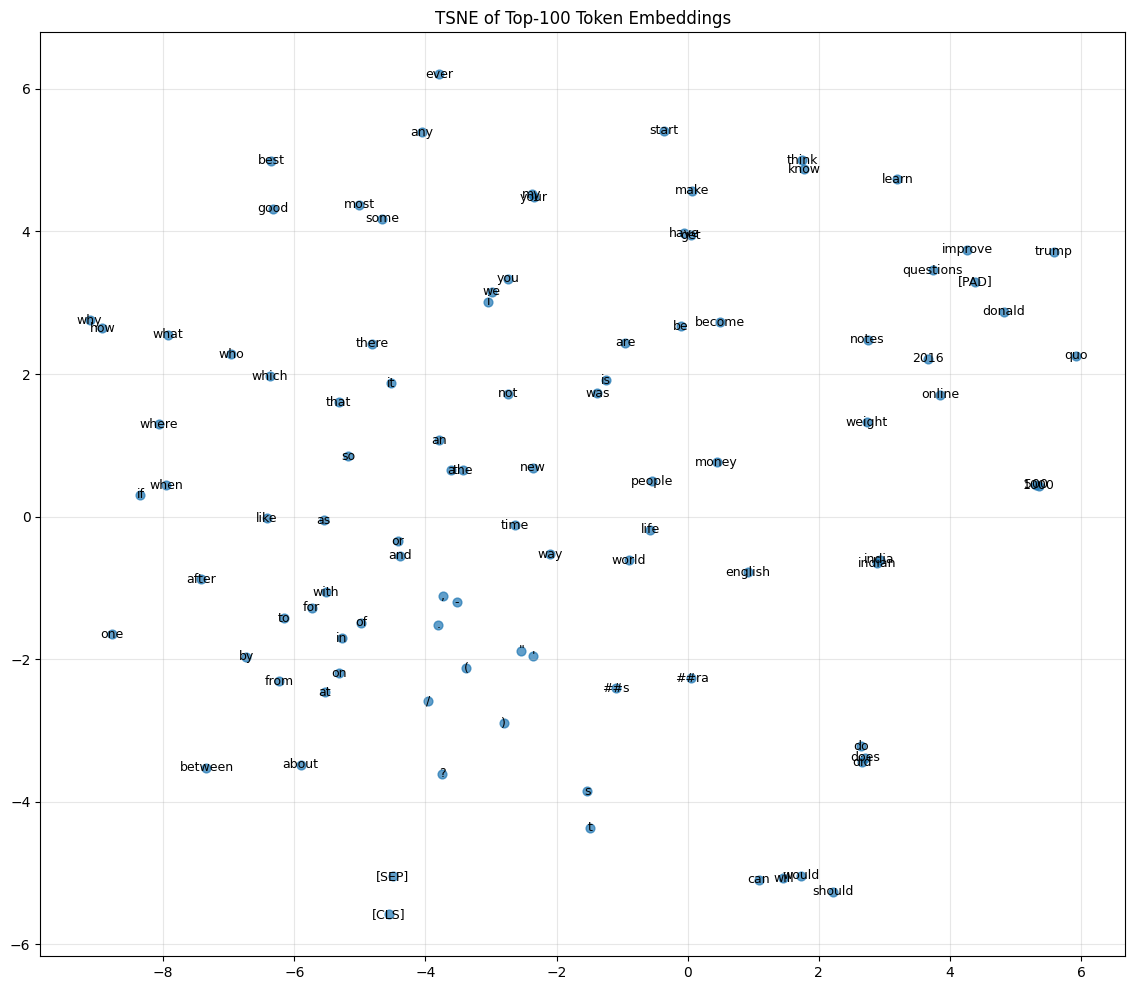

In [15]:
from shortcutfm.analysis.embedding_analysis import (
    get_top_k_frequent_tokens,
    get_token_embeddings,
    plot_token_embeddings_2d,
)
from datasets import DatasetDict

tokenizer = token_results["model"].criterion.flow_matching_criterion.tokenizer
model = token_results["model"]

splits = DatasetDict.load_from_disk("../datasets/tokenized/bert-base-uncased/QQP-Official")
train_dataset = splits["train"]

# 1. Get top-k frequent tokens
token_ids, token_texts = get_top_k_frequent_tokens(tokenizer, train_dataset, k=100)

# 2. Get their embeddings
embeddings = get_token_embeddings(model, token_ids)

# 3. Visualize with t-SNE or UMAP
plot_token_embeddings_2d(embeddings, token_texts, method='tsne')  # or method='umap'

## Bert Embeddings

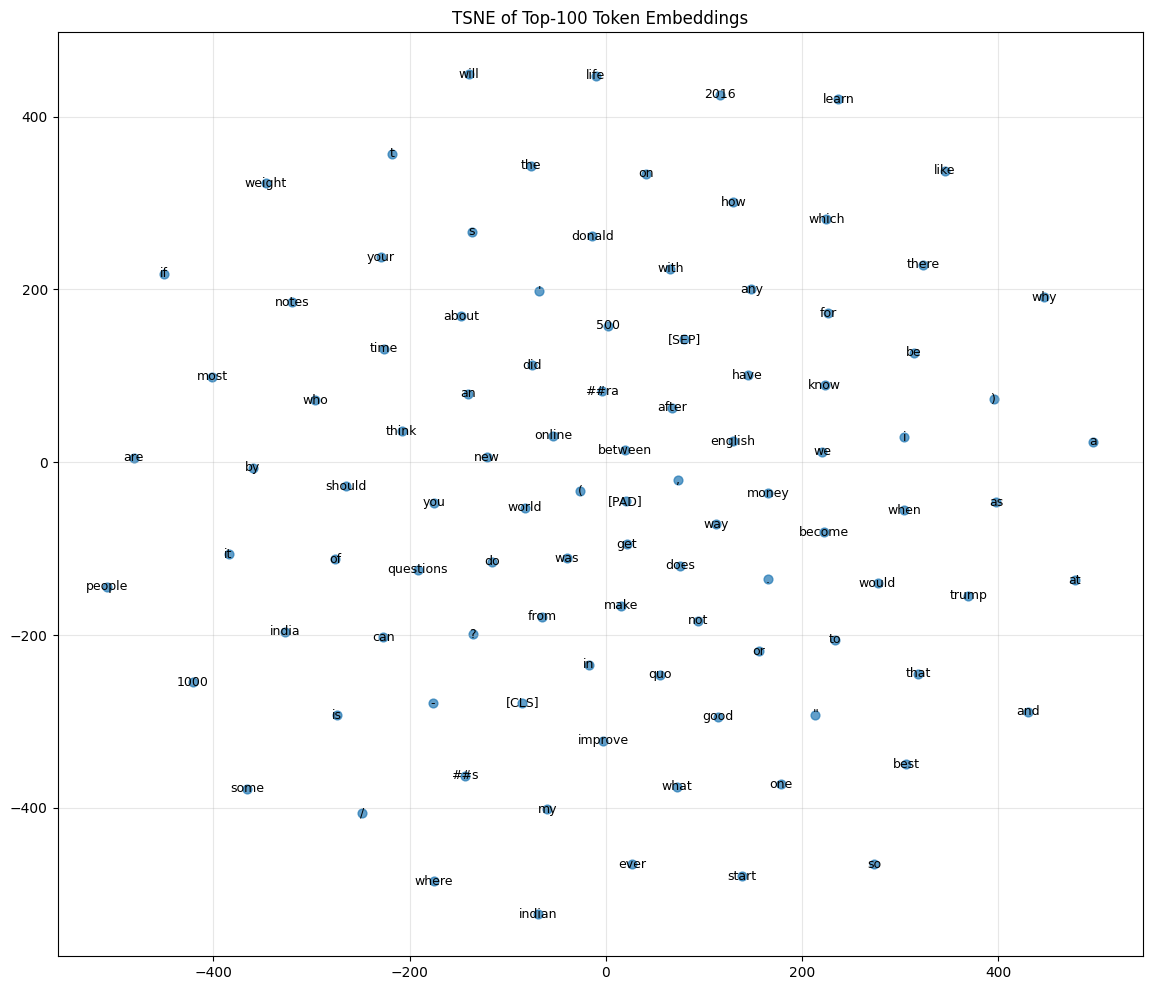

In [16]:
from transformers import AutoConfig, BertModel, ModernBertModel

bert_config = AutoConfig.from_pretrained("bert-base-uncased")

bert_base = BertModel(bert_config)
with torch.no_grad():
    bert_embeddings_weights = bert_base.embeddings.word_embeddings.weight
    token_ids_tensor = torch.tensor(token_ids, device=bert_embeddings_weights.device)
    bert_embeddings = bert_embeddings_weights[token_ids_tensor]
    bert_embeddings = bert_embeddings.detach().cpu()

plot_token_embeddings_2d(bert_embeddings, token_texts, method='tsne')  # or method='umap'


In [19]:
from shortcutfm.analysis.embedding_analysis import calculate_embedding_statistics


bert_embedding_statistics = calculate_embedding_statistics(bert_embeddings_weights.detach().cpu())
learned_embedding_statistics = calculate_embedding_statistics(model.criterion.model.module.word_embedding.weight.detach().cpu())

print(bert_embedding_statistics)
print(learned_embedding_statistics)


{'isotropy': 0.7286217212677002, 'avg_norm': 0.5540827512741089, 'norm_std': 0.014432871714234352, 'mean_nearest_dist': 0.5540989637374878, 'nearest_dist_std': 0.014083904214203358, 'mean_pairwise_dist': 0.7835933566093445, 'pairwise_dist_std': 0.02004145085811615}
{'isotropy': 0.01013472955673933, 'avg_norm': 1.4014137983322144, 'norm_std': 0.1932162493467331, 'mean_nearest_dist': 1.026978850364685, 'nearest_dist_std': 0.2557842433452606, 'mean_pairwise_dist': 1.4848486185073853, 'pairwise_dist_std': 0.17605653405189514}


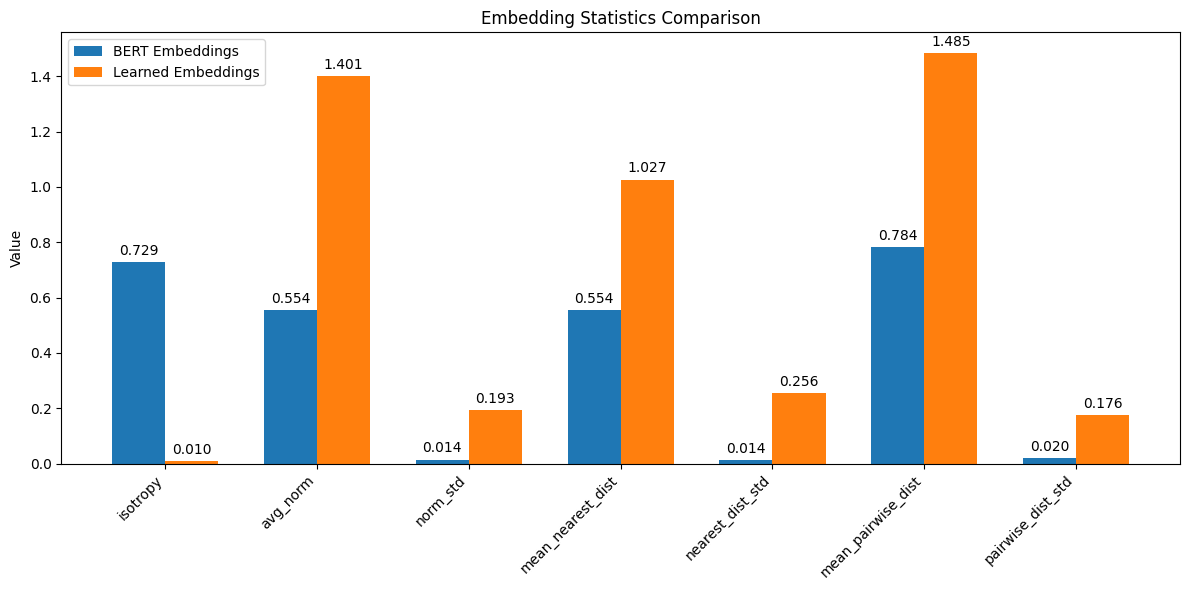

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Create a bar plot comparing the statistics
metrics = list(bert_embedding_statistics.keys())
bert_values = [bert_embedding_statistics[m] for m in metrics]
learned_values = [learned_embedding_statistics[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, bert_values, width, label='BERT Embeddings')
rects2 = ax.bar(x + width/2, learned_values, width, label='Learned Embeddings')

ax.set_ylabel('Value')
ax.set_title('Embedding Statistics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45, ha='right')
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()
